Process_image.py - takes as input 16x16x3 matrix, corresponding to a Macroblock of the image

Outputs the result of the DCT transformation and Quantization

In [1]:
import numpy as np
import sys
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import empty,arange,exp,real,imag,pi
from numpy.fft import rfft,irfft

Definitions for 2D DCT

Functions origionally written by Mark Newman <mejn@umich.edu>

Accessed from http://www-personal.umich.edu/~mejn/computational-physics/dcst.py

Source contains blurb : "You may use, share, or modify this file freely"

In [2]:
#### 2D DCT ####
def dct2(y):
    def dct(y):
        N = len(y)
        y2 = empty(2*N,float)
        y2[:N] = y[:]
        y2[N:] = y[::-1]

        c = rfft(y2)
        phi = exp(-1j*pi*arange(N)/(2*N))
        return real(phi*c[:N])
    
    M = y.shape[0]
    N = y.shape[1]
    a = empty([M,N],float)
    b = empty([M,N],float)

    for i in range(M):
        a[i,:] = dct(y[i,:])
    for j in range(N):
        b[:,j] = dct(a[:,j])

    return b

In [3]:
img_name = 'Add.png'
img_name = 'baboon.jpg'
rgb = cv2.imread(img_name,1)[:16,:16]
QF = 1

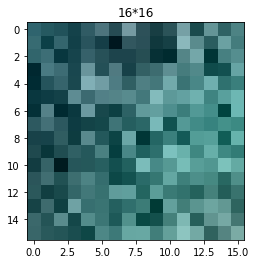

In [4]:
plt.title('16*16')
plt.imshow(rgb)

In [5]:
# Split bgr color channels
blue,green,red = cv2.split(rgb)
gray = cv2.cvtColor(rgb , cv2.COLOR_BGR2GRAY) # Convert color form BGR to Gray

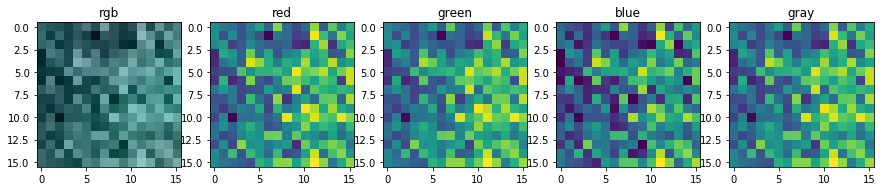

In [6]:
plt.figure(figsize=(15,5))
plt.subplot(151)
plt.title('rgb')
plt.imshow(rgb)
plt.subplot(152)
plt.title('red')
plt.imshow(red)
plt.subplot(153)
plt.title('green')
plt.imshow(green)
plt.subplot(154)
plt.title('blue')
plt.imshow(blue)
plt.subplot(155)
plt.title('gray')
plt.imshow(gray)

In [7]:
# Convert color form BGR to Y_Cr_Cb
YCrCb = cv2.cvtColor(rgb , cv2.COLOR_RGB2YCR_CB) 
# Split Y_Cb_Cr channels
Y,Cb,Cr = cv2.split(YCrCb)

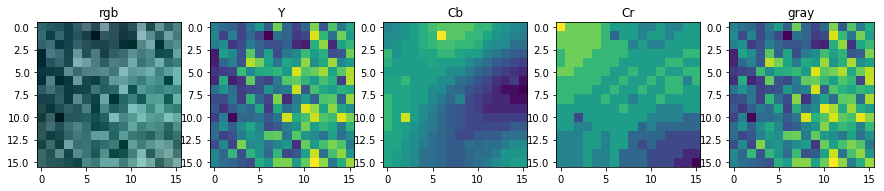

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(151)
plt.title('rgb')
plt.imshow(rgb)
plt.subplot(152)
plt.title('Y')
plt.imshow(Y)
plt.subplot(153)
plt.title('Cb')
plt.imshow(Cb)
plt.subplot(154)
plt.title('Cr')
plt.imshow(Cr)
plt.subplot(155)
plt.title('gray')
plt.imshow(gray)

In [9]:
Y1 = Y[:8,:8]
Y2 = Y[:8,8:]
Y3 = Y[8:,:8]
Y4 = Y[8:,8:]

In [10]:
# The strategy of subsampling is to keep the top left pixel for each 2x2 block
# We can also compute the mean of 2x2 block, the let it be the summary of the small block
def subsample(src):
    tmp = []
    for i in range(0,len(src),2):
        #print(i)
        #print(Cb[i])
        #print(Cb[i][::2])
        tmp.append(src[i][::2])
        #print(tmp)
    tmp = np.array(tmp)
    return tmp

In [11]:
subsample_Cb = subsample(Cb)
subsample_Cr = subsample(Cr)

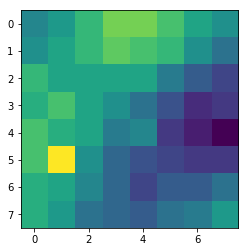

In [12]:
plt.imshow(subsample_Cb)

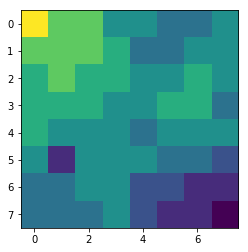

In [13]:
plt.imshow(subsample_Cr)

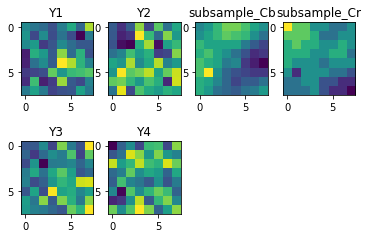

In [14]:
plt.subplot(241)
plt.title('Y1')
plt.imshow(Y1)
plt.subplot(242)
plt.title('Y2')
plt.imshow(Y2)
plt.subplot(243)
plt.title('subsample_Cb')
plt.imshow(subsample_Cb)
plt.subplot(244)
plt.title('subsample_Cr')
plt.imshow(subsample_Cr)
plt.subplot(245)
plt.title('Y3')
plt.imshow(Y3)
plt.subplot(246)
plt.title('Y4')
plt.imshow(Y4)

In [15]:
dct2_Y1 = dct2(Y1) 
dct2_Y2 = dct2(Y2) 
dct2_Y3 = dct2(Y3) 
dct2_Y4 = dct2(Y4) 
dct2_Cb = dct2(subsample_Cb) 
dct2_Cr = dct2(subsample_Cr) 

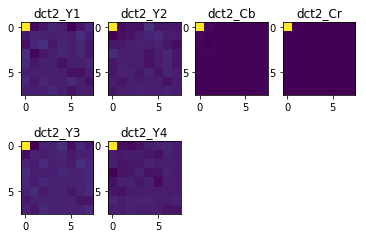

In [16]:
plt.subplot(241)
plt.title('dct2_Y1')
plt.imshow(dct2_Y1)
plt.subplot(242)
plt.title('dct2_Y2')
plt.imshow(dct2_Y2)
plt.subplot(243)
plt.title('dct2_Cb')
plt.imshow(dct2_Cb)
plt.subplot(244)
plt.title('dct2_Cr')
plt.imshow(dct2_Cr)
plt.subplot(245)
plt.title('dct2_Y3')
plt.imshow(dct2_Y3)
plt.subplot(246)
plt.title('dct2_Y4')
plt.imshow(dct2_Y4)

In [17]:
# Define quantization matrix
# Source: https://en.wikipedia.org/wiki/MPEG-1#Quantization
quant_intra = np.matrix('16 11 10 16 24 40 51 61;12 12 14 19 26 58 60 55;14 13 16 24 40 57 69 56;14 17 22 29 51 87 80 62;18 22 37 56 68 109 103 77;24 35 55 64 81 104 113 92;49 64 78 87 103 121 120 101;72 92 95 98 112 100 103 99')
quant_intra

matrix([[ 16,  11,  10,  16,  24,  40,  51,  61],
        [ 12,  12,  14,  19,  26,  58,  60,  55],
        [ 14,  13,  16,  24,  40,  57,  69,  56],
        [ 14,  17,  22,  29,  51,  87,  80,  62],
        [ 18,  22,  37,  56,  68, 109, 103,  77],
        [ 24,  35,  55,  64,  81, 104, 113,  92],
        [ 49,  64,  78,  87, 103, 121, 120, 101],
        [ 72,  92,  95,  98, 112, 100, 103,  99]])

In [18]:
# Quantization
QF = 1
def quantize(F):
    quant_matrix=np.ceil(quant_intra*QF)
    quant_matrix[quant_matrix>255]=255
    return np.rint(F/quant_matrix).astype(np.int)

In [19]:
qtz_Y1 = quantize(dct2_Y1) 
qtz_Y2 = quantize(dct2_Y2) 
qtz_Y3 = quantize(dct2_Y3) 
qtz_Y4 = quantize(dct2_Y4) 
qtz_Cb = quantize(dct2_Cb) 
qtz_Cr = quantize(dct2_Cr) 

In [20]:
print(dct2_Y1)

[[  1.99160000e+04  -1.28055126e+03  -3.87260171e+02   4.92110504e+02
   -1.97989899e+01  -1.81520588e+03  -5.28421763e+02   6.11230998e+02]
 [ -3.00452604e+02   4.77505635e+02   3.32171002e+02  -2.17400996e+00
    3.83813981e+02   1.83524513e+01   9.16180276e+02   1.67727513e-01]
 [ -8.70818183e+02   5.95184924e+02   1.34326616e+03  -4.02131928e+02
    4.72142836e+02   8.39857915e+00   4.96732106e+02  -3.88724086e+02]
 [  1.20735875e+03  -1.40549706e+03  -3.89737219e+02  -6.61769053e+00
    4.11635162e+02  -8.89790214e+00   5.18462767e+02  -4.36808044e+02]
 [  9.81464212e+02  -3.75761194e+02  -7.57674540e+00   4.88753769e+00
   -8.46000000e+02  -1.55817711e+01   1.82918815e+01   4.91813832e+02]
 [ -2.41891404e+00   1.91999631e+01  -2.05195935e+00   1.24423349e+00
    1.39974078e+01  -7.47150996e+02  -8.07612759e+02   2.88475426e+00]
 [  5.65823022e+02  -4.54753125e+02   4.84732106e+02  -1.15830102e+01
    5.75698340e+00   8.67494279e+02   1.67338392e+01  -7.32935858e+02]
 [ -1.9779286

In [21]:
qtz_Y1

matrix([[1245, -116,  -39,   31,   -1,  -45,  -10,   10],
        [ -25,   40,   24,    0,   15,    0,   15,    0],
        [ -62,   46,   84,  -17,   12,    0,    7,   -7],
        [  86,  -83,  -18,    0,    8,    0,    6,   -7],
        [  55,  -17,    0,    0,  -12,    0,    0,    6],
        [   0,    1,    0,    0,    0,   -7,   -7,    0],
        [  12,   -7,    6,    0,    0,    7,    0,   -7],
        [   0,    0,    0,    7,    0,   -7,    0,    0]])

In [22]:
def prefix_0(s):
    i=0
    count = 0
    while s[i]==0 :
        count+=1
        #print(i,len(s)-1)
        if i==len(s)-1:
            return count
        i+=1
    return count

In [23]:
zz_indices = [ 0,  1,  8, 16,  9,  2,  3, 10,
               17, 24, 32, 25, 18, 11, 4,  5,
               12, 19, 26, 33, 40, 48, 41, 34,
               27, 20, 13,  6,  7, 14, 21, 28,
               35, 42, 49, 56, 57, 50, 43, 36,
               29, 22, 15, 23, 30, 37, 44, 51,
               58, 59, 52, 45, 38, 31, 39, 46,
               53, 60, 61, 54, 47, 55, 62, 63]

In [24]:
zz_series = [qtz_Y2.A1[i] for i in zz_indices]
print(zz_series)

[1732, -112, -193, -29, -94, -80, -59, -47, -24, 115, -28, 20, 0, 0, 71, -15, 30, 16, 0, 17, -22, 0, 12, 0, 0, 0, 25, -11, -10, 0, 7, -16, 0, 8, -7, -9, 0, 0, -8, -13, 0, -8, 0, -20, 13, 0, 7, 0, 0, 7, 0, -7, 7, -7, -7, 7, 0, 0, 0, -7, 0, 0, 7, 0]


In [25]:
def run_level(tmp):
    encoded_string = []
    while True:
        a = prefix_0(tmp)
        if a==len(tmp):
            break
        #print([a,tmp[a]])
        encoded_string.append([a,tmp[a]])
        tmp = tmp[a+1:]
    return encoded_string

In [26]:
def encode(tmp):
    encoded_string = [tmp.pop(0)]
    encoded_string += run_level(tmp)
    encoded_string.append('EOB')
    return encoded_string

In [27]:
# example of encode
tmp = [1,2,0,0,1,0,0,0,2,0,3,0,0,0,0,0]
encode(tmp)

[1, [0, 2], [2, 1], [3, 2], [1, 3], 'EOB']

In [28]:
encode(zz_series)

[1732,
 [0, -112],
 [0, -193],
 [0, -29],
 [0, -94],
 [0, -80],
 [0, -59],
 [0, -47],
 [0, -24],
 [0, 115],
 [0, -28],
 [0, 20],
 [2, 71],
 [0, -15],
 [0, 30],
 [0, 16],
 [1, 17],
 [0, -22],
 [1, 12],
 [3, 25],
 [0, -11],
 [0, -10],
 [1, 7],
 [0, -16],
 [1, 8],
 [0, -7],
 [0, -9],
 [2, -8],
 [0, -13],
 [1, -8],
 [1, -20],
 [0, 13],
 [1, 7],
 [2, 7],
 [1, -7],
 [0, 7],
 [0, -7],
 [0, -7],
 [0, 7],
 [3, -7],
 [2, 7],
 'EOB']

In [29]:
qtz_Y2

matrix([[1732, -112,  -80,  -59,   71,  -15,  -11,  -10],
        [-193,  -94,  -47,    0,   30,   25,    0,    0],
        [ -29,  -24,    0,   16,    0,    7,   -8,  -20],
        [ 115,   20,    0,    0,  -16,    0,   13,   -7],
        [ -28,   17,    0,    0,  -13,    0,    7,   -7],
        [ -22,   12,    8,   -8,    7,   -7,    7,    0],
        [   0,   -7,    0,    0,    0,    0,   -7,    0],
        [  -9,    0,    0,    7,    0,    0,    7,    0]])